## DS4A: MinJusticia
### Reducing the recidivim risk for people released from jail between 2010 and 2019 <br> 


Laura A Goyeneche <br>

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')

In [2]:
# Import data
inmate     = pd.read_csv('data/ReincidenciaPospenadosNal26Mayo2020Rev.csv', sep = ';', skiprows = 5, encoding= 'unicode_escape')
inmatevars = pd.read_excel('data/ReincidenciaPospenadosNal2010-31Mayo2020Rev_con variables demograficas.xlsx', skiprows = 6) 

In [3]:
# Data sample
inmatevars.head(3)

,INTERNOEN,DELITO,TENTATIVA,AGRAVADO,CALIFICADO,FECHA_INGRESO,FECHA_SALIDA,FECHA_CAPTURA,SITUACION_JURIDICA,ANO_NACIMIENTO,...,ACTIVIDADES_ENSEÑANZA,NIVEL_EDUCATIVO,HIJOS_MENORES,CONDIC_EXPECIONAL,CODIGO_ESTABLECIMIENTO,ESTABLECIMIENTO,DEPTO_ESTABLECIMIENTO,MPIO_ESTABLECIMIENTO,REGIONAL,ESTADO
0,5496C737C624136DB406CFC6744C684C070A3CD8,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,N,N,N,01/01/10,12/05/11,30/12/09,CO,1972,...,NO,CICLO III,SI,NaN,502,EPMSC MEDELLIN,ANTIOQUIA,MEDELLIN,NOROESTE,Baja
1,1097561F306939C26DB4AC60377063DA7E2B079F,TRAFICO FABRICACION O PORTE DE ESTUPEFACIENTES,N,N,N,01/01/10,05/12/11,30/12/09,CO,1962,...,NO,CICLO I,SI,NaN,502,EPMSC MEDELLIN,ANTIOQUIA,MEDELLIN,NOROESTE,Baja
2,CB7033A707ADE673139F8A17CAD26AD54696C135,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,N,N,N,01/01/10,06/08/13,30/12/09,CO,1982,...,NO,CICLO I,SI,NaN,235,EPAMSCAS POPAYAN (ERE),CAUCA,POPAYAN,OCCIDENTE,Baja


In [4]:
# Feature changes
inmatevars.FECHA_INGRESO = pd.to_datetime(inmatevars.FECHA_INGRESO)
inmatevars.FECHA_SALIDA  = pd.to_datetime(inmatevars.FECHA_SALIDA)
inmatevars.FECHA_CAPTURA = pd.to_datetime(inmatevars.FECHA_CAPTURA)

In [12]:
# Data columns
list(inmatevars.columns)

['INTERNOEN',
 'DELITO',
 'TENTATIVA',
 'AGRAVADO',
 'CALIFICADO',
 'FECHA_INGRESO',
 'FECHA_SALIDA',
 'FECHA_CAPTURA',
 'SITUACION_JURIDICA',
 'ANO_NACIMIENTO',
 'EDAD',
 'GENERO',
 'ESTADO_CIVIL',
 'PAIS_INTERNO',
 'DEPARTAMENTO',
 'CIUDAD',
 'REINCIDENTE',
 'ESTADO_INGRESO',
 'ACTIVIDADES_TRABAJO',
 'ACTIVIDADES_ESTUDIO',
 'ACTIVIDADES_ENSEÑANZA',
 'NIVEL_EDUCATIVO',
 'HIJOS_MENORES',
 'CONDIC_EXPECIONAL',
 'CODIGO_ESTABLECIMIENTO',
 'ESTABLECIMIENTO',
 'DEPTO_ESTABLECIMIENTO',
 'MPIO_ESTABLECIMIENTO',
 'REGIONAL',
 'ESTADO']

In [6]:
# Basic information
print(
'''
Number of records (inmates, booking date): {} 
Number of variables                      : {} 
Number of inmates                        : {}
Number of crime types                    : {}
Start and end capture date               : {} and {}
Start and end booking date               : {} and {}
Start and end release date               : {} and {}
'''
.format(inmatevars.shape[0], 
        inmatevars.shape[1], 
        inmatevars.INTERNOEN.unique().shape[0], 
        inmatevars.DELITO.unique().shape[0],
        inmatevars.FECHA_CAPTURA.min(), inmatevars.FECHA_CAPTURA.max(),
        inmatevars.FECHA_INGRESO.min(), inmatevars.FECHA_INGRESO.max(),
        inmatevars.FECHA_SALIDA.dropna().min(), inmatevars.FECHA_SALIDA.dropna().max())
)


Number of records (inmates, booking date): 142499 
Number of variables                      : 30 
Number of inmates                        : 78683
Number of crime types                    : 259
Start and end capture date               : 1978-12-16 00:00:00 and 2020-12-05 00:00:00
Start and end booking date               : 2010-01-01 00:00:00 and 2020-12-05 00:00:00
Start and end release date               : 2001-03-04 00:00:00 and 2020-12-05 00:00:00



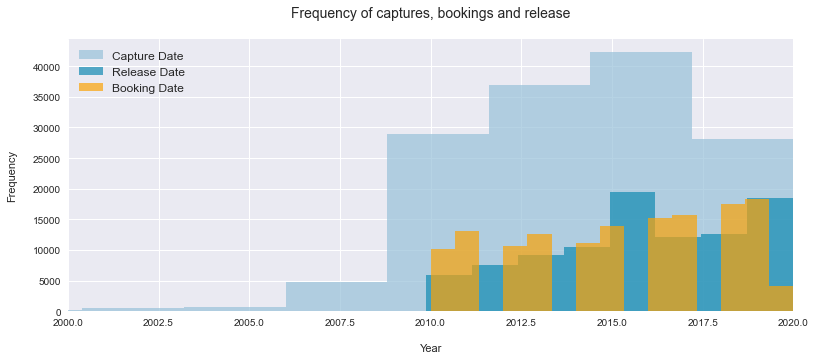

In [7]:
plt.figure(figsize = (13,5))
plt.hist(inmatevars.FECHA_CAPTURA.dt.year        , bins = 15, label = 'Capture Date', color = '#98c1d9', alpha = 0.7)
plt.hist(inmatevars.FECHA_SALIDA.dropna().dt.year, bins = 15, label = 'Release Date', color = '#118ab2', alpha = 0.7)
plt.hist(inmatevars.FECHA_INGRESO.dt.year        , bins = 15, label = 'Booking Date', color = '#faa307', alpha = 0.7)
plt.title('Frequency of captures, bookings and release\n', fontsize = 14)
plt.ylabel('Frequency\n')
plt.xlabel('\nYear')
plt.xlim(2000,2020)
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

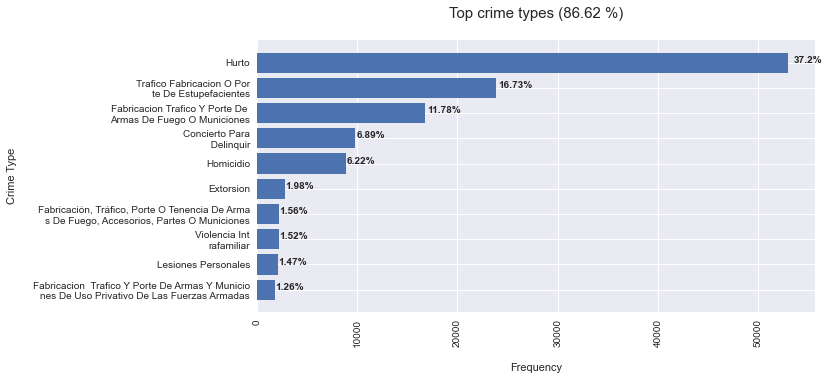

In [8]:
temp               = inmatevars.DELITO.str.title().value_counts().to_frame().reset_index().rename(columns = {'index':'DELITONAME'})
temp['DELITO_PER'] = round(temp.DELITO*100/temp.DELITO.sum(),2)
temp               = temp.head(10).sort_values(by = 'DELITO', ascending = True)
temp.DELITONAME    = temp.DELITONAME.apply(lambda x: x[:int(len(x)/2 + 2)] + '\n' + x[int(len(x)/2 + 2):] if len(x) > 20 else x)

plt.figure(figsize = (10,5))
plt.barh(temp.DELITONAME, temp.DELITO)
plt.xticks(rotation = 90)
plt.title('Top crime types (%.2f %%)\n' % (temp.DELITO.sum()*100/inmatevars.shape[0]), fontsize = 15)

for i in range(len(temp)):
    plt.text(1.01*temp.DELITO[i], temp.DELITONAME[i], str(temp.DELITO_PER[i]) + '%', fontweight = 'bold')

plt.ylabel('Crime Type\n')
plt.xlabel('\nFrequency')
plt.show()

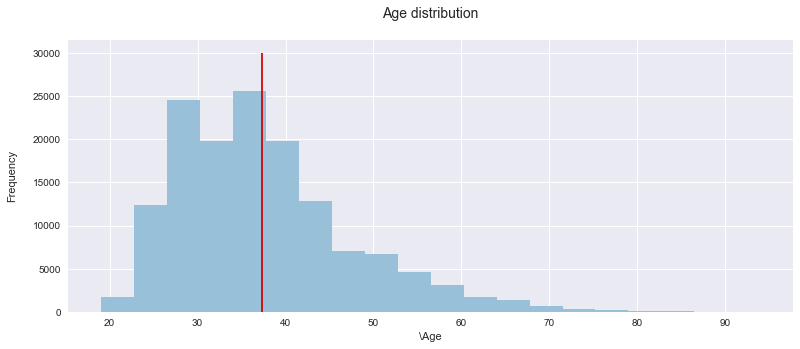

In [9]:
plt.figure(figsize = (13,5))
plt.hist(inmatevars.EDAD, bins = 20, label = 'Capture Date', color = '#98c1d9')
plt.vlines(inmatevars.EDAD.mean(), 0, 30000, color = '#d00000')
plt.title('Age distribution\n', fontsize = 14)
plt.ylabel('Frequency\n')
plt.xlabel('\Age')
plt.show()